# Word Segmentation Modelling (version : alam.1.3)

This is the modelling documentation of Word Segmentation

First Structured :


Input :

    INPUT LENGTH =15
    TRAIN = 90k data (Random state : 342)
    WORD2VEC 50
    

output :

    Multi LSTM


## Plan

    [*] Get Data
    [*] Transform the data
    [ ] Prepare the model
    [ ] Train it

In [68]:
%matplotlib inline
import sys
sys.path.append('../scr/')
import pandas as pd
import torch
import numpy as np
import os
import pickle
import WordSegmenTools as wst
from torch.autograd import Variable
import random
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
import time

In [2]:
PATH_DATA_RAW='../../data/raw/'
PATH_DATA_CLN='../../data/clean/'
PATH_MODEL='../../data/model/'

In [3]:
os.listdir(PATH_DATA_CLN)

['data_clean_100k.res']

In [4]:
os.listdir(PATH_MODEL)

['char_embed_25.res', 'char_embed_50.res', 'char_embed_75.res']

## Get Data

In [5]:
SEQ_LENGTH=15

In [6]:
# data_cln=pd.read_csv(PATH_DATA_CLN+'data_clean_100k.res')
data_cln=pickle.load(open(PATH_DATA_CLN+'data_clean_100k.res','rb'))
w2v = Word2Vec.load(PATH_MODEL+"char_embed_50.res")

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
data_cln['len_source']=data_cln.source.apply(len)
data_used=data_cln[data_cln.len_source==SEQ_LENGTH]
data_used=data_used.reset_index()[['source','target','index']]
data_used.columns=['source','target','ids']

In [8]:
data_used.sample(10)

,source,target,ids
23866,banksilamselasa,bank silam selasa,1512348
63224,gunnarareamaung,gunnar area maung,1698898
43201,keapadabeatkita,keapada beat kita,1604852
33218,tibaadatersebut,tiba ada tersebut,1556976
58341,milansehinggafa,milan sehingga fa,1676041
80344,dantelahdikutip,dan telah dikutip,1780426
72302,baratjakartadan,barat jakarta dan,1742038
36818,bahasaalumunium,bahasa alumunium,1574309
75196,lagadeltapivoli,laga del tapi voli,1755889
72419,visimematangkan,visi mematangkan,1742581


## Transform Data

In [9]:
data_used['flag_space'] = data_used['target'].map(wst.get_flag_space)
word2idx, idx2word = wst.get_label_index(data_used.source)

In [10]:
data_used_train=data_used.sample(90000,random_state=342)
data_used_test=data_used[~(data_used.ids.isin(data_used_train.ids))]

In [11]:
## Target 
Y_tr=np.array(data_used_train.flag_space.apply(list).tolist(),dtype=np.double)
Y_tr=Y_tr.reshape(-1,SEQ_LENGTH,1)
Y_te=np.array(data_used_test.flag_space.apply(list).tolist(),dtype=np.double)
Y_te=Y_te.reshape(-1,SEQ_LENGTH,1)

encoder = OneHotEncoder()
encoder.fit(Y_tr.reshape(-1,1))

Y_tr=encoder.transform(Y_tr.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))
Y_te=encoder.transform(Y_te.reshape(-1,1)).toarray().reshape(-1,SEQ_LENGTH,len(encoder.categories_[0]))

## Source
X_tr=wst.char_vectorizer_word2vec(data_used_train.source.tolist(), w2v, SEQ_LENGTH)
X_te=wst.char_vectorizer_word2vec(data_used_test.source.tolist(), w2v, SEQ_LENGTH)

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [12]:
# word2idx

In [13]:
X_tr.shape

(90000, 15, 50)

In [14]:
X_te.shape

(10000, 15, 50)

## Prepare the Model

In [45]:
class MultiLstm(torch.nn.Module):

    def __init__(self, input_size, output_size, hidden_dim0, hidden_dim1, Layers):        
        super(MultiLstm, self).__init__()
        self.input_dim = input_size
        self.hidden_dim0 = hidden_dim0
        self.hidden_dim1 = hidden_dim1

        # self.lstm = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.lstm1 = torch.nn.LSTM(self.input_dim, self.hidden_dim0)
        self.lstm2 = torch.nn.LSTM(self.hidden_dim0, self.hidden_dim1)
        self.lstm3 = torch.nn.LSTM(self.hidden_dim1, self.hidden_dim1, num_layers=Layers)
        self.linear = torch.nn.Linear(self.hidden_dim1, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input):
        torch.manual_seed(200)
        batch_size=len(input)
        embedding_len=len(input[0][0])        
        input=input.view(batch_size,len(input[0]), -1)
        
        lstm_out, hidden1 = self.lstm1(input)
        lstm_out, hidden2 = self.lstm2(lstm_out)
        out, hidden3 = self.lstm3(lstm_out)
        y_pred = self.linear(out)
        y_pred = self.sigmoid(y_pred)
        
        return y_pred
    
## Remember : Batch, Seq, Embedding

In [46]:
# XX=torch.rand(1,5,10)
# LL=torch.nn.LSTM(10, 20,num_layers=3)

# A,[B,C]=LL(XX)
# A.size(),B.size()

# LLi=torch.nn.Linear(20, 2)
# A1=LLi(A)
# A1.size()

In [47]:
def data_batching_torch(X,y,batch):
    batches=[(torch.from_numpy(X[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'),
              torch.from_numpy(y[i*(batch):i*(batch)+batch]).type('torch.DoubleTensor'))   
                  for i in range(int(len(X)/batch)+1)]
    return batches

In [48]:
BATCH_SIZE=25
training_samples=data_batching_torch(X_tr,Y_tr,BATCH_SIZE)
len(training_samples)

3601

In [49]:
random.seed(100)
sample_val=random.sample(training_samples,540)
sample_train=list(set(training_samples)-set(sample_val))

In [57]:
# Get the model
INPUT_LENGTH=w2v.vector_size
LAYERS=3
HIDDEN_LAYER0=30
HIDDEN_LAYER1=10
OUT_DIM=2
learningRate=0.0002

model_lstm=MultiLstm(input_size=INPUT_LENGTH, output_size=OUT_DIM, hidden_dim0=HIDDEN_LAYER0, hidden_dim1=HIDDEN_LAYER1, Layers=LAYERS)
model_lstm.double()

MultiLstm(
  (lstm1): LSTM(50, 30)
  (lstm2): LSTM(30, 10)
  (lstm3): LSTM(10, 10, num_layers=3)
  (linear): Linear(in_features=10, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [58]:
training_samples[0][0].size()

torch.Size([25, 15, 50])

In [59]:
# model_lstm(training_samples[0][0])

In [60]:
## Choose the optimizer and criterion
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(),lr=learningRate)
# optimizer = torch.optim.SGD(model.parameters(),lr=learningRate)

In [61]:
AA=training_samples[0][1]

In [62]:
AA.type()

'torch.DoubleTensor'

## Train it

In [66]:
epochs=24
model_lstm.double()
# running_loss_train_ls=[]
# running_loss_test_ls=[]

for epoch in range(epochs):
    L=time.time()
    model_lstm.train()
    running_loss_train = 0
    running_loss_test = 0
    # Converting inputs and labels to Variable
    
    for batch_idx, (data, target) in enumerate(sample_train, 1):
        if data.size()[0]>0:
            inputs = Variable(data)
            labels = Variable(target)
            optimizer.zero_grad()
            outputs= model_lstm(inputs)
            
            # get loss for the predicted output
            loss = criterion(outputs, labels)
            loss.backward()
            
            # update parameters
            optimizer.step()
            running_loss_train += (loss.item() - running_loss_train) / batch_idx
            
    model_lstm.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(sample_val, 1):
            if data.size()[0]>0:
                inputs = Variable(data)
                labels = Variable(target)
                outputs= model_lstm(inputs)
                loss = criterion(outputs, labels)
                running_loss_test += (loss.item() - running_loss_test) / batch_idx
    
    running_loss_train_ls.append(running_loss_train)
    running_loss_test_ls.append(running_loss_test)
        
    if epoch % 2 == 0:
        print('----------'+str(epoch)+'----------')
        print("running loss train", running_loss_train)
        print("running loss val", running_loss_test)
        print("time every epoch: "+str((time.time()-L)/60))

----------0----------
running loss train 0.31693479360248156
running loss val 0.31954968146132856
time every epoch: 2.2857335527737934
----------2----------
running loss train 0.3168706785146543
running loss val 0.31956313510409295
time every epoch: 2.1900426348050437
----------4----------
running loss train 0.31680739183143836
running loss val 0.31957919264358714
time every epoch: 2.164198136329651
----------6----------
running loss train 0.316744848410072
running loss val 0.31959831390819754
time every epoch: 2.409794569015503
----------8----------
running loss train 0.316683026569623
running loss val 0.3196208191760337
time every epoch: 2.1732556502024334
----------10----------
running loss train 0.3166219315069723
running loss val 0.3196467652397816
time every epoch: 2.160841103394826
----------12----------
running loss train 0.3165615297602946
running loss val 0.31967613199146644
time every epoch: 2.170191931724548
----------14----------
running loss train 0.31650170924163595
runn

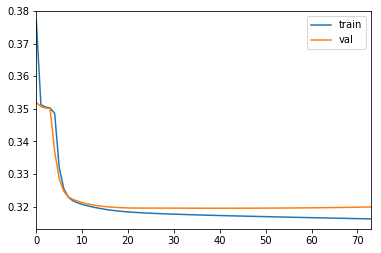

In [69]:
data_eval=pd.DataFrame({'train':running_loss_train_ls,'val':running_loss_test_ls})
data_eval.plot()

In [70]:
1+1

2

In [72]:
model_lstm.eval()

MultiLstm(
  (lstm1): LSTM(50, 30)
  (lstm2): LSTM(30, 10)
  (lstm3): LSTM(10, 10, num_layers=3)
  (linear): Linear(in_features=10, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [74]:
## Training
XX=X_tr.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model_lstm(XX)

In [75]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['10', '10', '10', '10', '10', '10', '10', '10', '10', '10']

In [76]:
data_used_train['y_pred']=yy0

ValueError: Length of values does not match length of index

In [ ]:
data_used_train.sample(10)

## Test it

In [37]:
## Test it
XX=X_te.copy()
XX=Variable(torch.from_numpy(XX).type('torch.DoubleTensor'))
yy=model(XX)

In [38]:
yy0=yy[0].data.numpy()
yy0=(yy0>0.5).astype(int).astype(str)
yy0=[''.join(i) for i in yy0]
yy0[:10]

['000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000',
 '000000000000000']

In [39]:
data_used_test['y_pred']=yy0

/Users/alamhanz/anaconda/envs/word_s/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
data_used_train.sample(10)

,source,target,ids,flag_space,y_pred
12342,sepakperusahaan,sepak perusahaan,1457750,000010000000000,000000000000000
9138,miliarmelakukan,miliar melakukan,1442854,000001000000000,000000000000000
3403,asalpendaftaran,asal pendaftaran,1416167,000100000000000,000000000000000
74342,jelasnyastadium,jelasnya stadium,1751813,000000010000000,000000000000000
12597,cmnphargaplakat,cmnp harga plakat,1459043,000100001000000,000000000000000
86940,bahwadenganyang,bahwa dengan yang,1811573,000010000010000,000000000000000
54344,terjadibniingin,terjadi bni ingin,1657235,000000100100000,000000000000000
8989,untuktetappiper,untuk tetap piper,1442103,000010000100000,000000000000000
15108,ratelalusamping,rate lalu samping,1471008,000100010000000,000000000000000
28477,danyangnokiadwi,dan yang nokia dwi,1534286,001000100001000,000000000000000
